In [48]:
import xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing, impute, model_selection
from sklearn.metrics import auc, confusion_matrix, roc_auc_score, roc_curve, precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from yellowbrick.classifier import ConfusionMatrix, ROCAUC
from yellowbrick.model_selection import LearningCurve  
from sklearn.experimental import enable_iterative_imputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from mlxtend.classifier import StackingClassifier

In [2]:
def tweak_titanic(df):
    df = df.drop(['name', 'ticket', 'home.dest', 'boat', 'body', 'cabin'], axis=1) \
           .pipe(pd.get_dummies, drop_first=True)

    return df

def get_train_test_X_y(df, y_col, test_size=0.3, std_cols=None):
    y = df[y_col]
    x = df.drop(y_col, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
    fi = impute.IterativeImputer()

    X_train.loc[:, num_cols]=fi.fit_transform(X_train[num_cols])
    X_test.loc[:, num_cols] = fi.transform(X_test[num_cols])

    if std_cols:
        std = preprocessing.StandardScaler()
        X_train.loc[:, std_cols] = std.fit_transform(X_train[std_cols])
        X_test.loc[:, std_cols] = std.transform(X_test[std_cols])

    return X_train, X_test, y_train, y_test

In [3]:
df = pd.read_csv('C:/Users/daniel.brooks/Documents/GitHub/References/titanic3.csv')
orig_df = df

df = df.drop(['name', 'ticket', 'home.dest', 'boat', 'body', 'cabin'], axis=1)

In [4]:
df = pd.get_dummies(df, drop_first=True)
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_male',
       'embarked_Q', 'embarked_S'],
      dtype='object')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('survived', axis=1), df['survived'], random_state=42, test_size=.30)

num_cols = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male']
imputer = impute.IterativeImputer()

imputed_train = imputer.fit_transform(X_train[num_cols])
imputed_test = imputer.transform(X_test[num_cols])

X_train.loc[:, num_cols] = imputed_train
X_test.loc[:, num_cols] = imputed_test

In [6]:
ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(ti_df, 'survived', std_cols=std_cols)

C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1737: Setti

In [7]:
# Dummy Model
dc = DummyClassifier()
dc.fit(X_train, y_train)
dc.score(X_test, y_test)
precision_score(y_test, dc.predict(X_test))

C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [8]:
# Compare series of models
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

for model in [DummyClassifier,
              LogisticRegression,
              DecisionTreeClassifier,
              KNeighborsClassifier,
              GaussianNB,
              SVC,
              RandomForestClassifier,
              xgboost.XGBClassifier]:

              cls = model()
              kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
              s = model_selection.cross_val_score(cls, X, y, scoring='roc_auc', cv=kfold)

              print(f"{model.__name__:22}  AUC: "
                    f"{s.mean():.3f} STD: {s.std():.2f}")

DummyClassifier         AUC: 0.500 STD: 0.00
LogisticRegression      AUC: 0.840 STD: 0.04
DecisionTreeClassifier  AUC: 0.760 STD: 0.03
KNeighborsClassifier    AUC: 0.829 STD: 0.03
GaussianNB              AUC: 0.812 STD: 0.05
SVC                     AUC: 0.838 STD: 0.03
RandomForestClassifier  AUC: 0.849 STD: 0.02


C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\daniel.brooks\AppData\Roaming\Pyt

[16:20:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\daniel.brooks\AppData\Roaming\Pyt

[16:20:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\daniel.brooks\AppData\Roaming\Pyt

[16:20:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier           AUC: 0.857 STD: 0.02


In [24]:
# Stacking Classifiers
clfs = [x() for x in [LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, GaussianNB, SVC, RandomForestClassifier]]

stack = StackingClassifier(
    classifiers=clfs,
    meta_classifier=LogisticRegression()
)

kfold = model_selection.KFold(n_splits=10)
s = model_selection.cross_val_score(stack, X, y, scoring="roc_auc", cv=kfold)

print(f"{stack.__class__.__name__:}  AUC: "
     f"{s.mean():.3f} STD: {s.std():.2f}")

StackingClassifier  AUC: 0.789 STD: 0.04


In [28]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

for col, val in sorted(zip(X_train.columns, rf.feature_importances_), key=lambda x:x[1], reverse=True)[:5]:
    print(f"{col:10}{val:10.3f}")

age            0.282
fare           0.269
sex_male       0.236
pclass         0.090
sibsp          0.050


C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


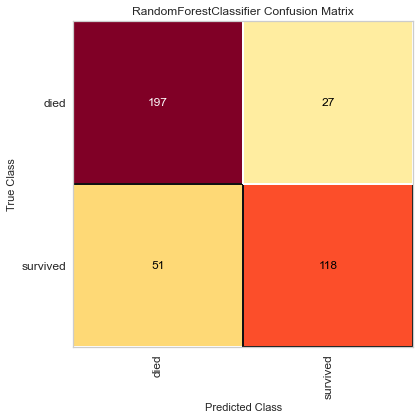

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [33]:
# Confusion Matrix
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

mapping = {0: 'died', 1: 'survived'}
fig, ax = plt.subplots(figsize=(6,6))
cm_viz = ConfusionMatrix(rf, classes=['died', 'survived'], label_encoder=mapping)
cm_viz.score(X_test, y_test)
cm_viz.poof()

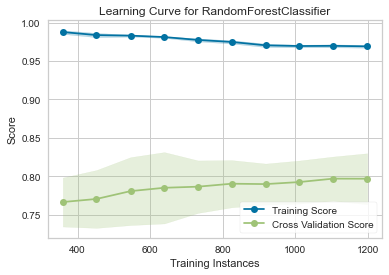

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [50]:
fig, ax = plt.subplots(figsize=(6, 4))
cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(
    rf,
    cv=cv,
    train_sizes=sizes,
    scoring="f1_weighted",
    n_jobs=4,
    ax=ax,
)
lc_viz.fit(X, y)
lc_viz.poof()
##